In [1]:
%pylab inline

import keras.backend as K
from keras import Input, Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.callbacks import *
from keras.losses import *
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints
from keras.models import load_model
from keras.utils import plot_model

import tensorflow as tf
from matplotlib import pyplot as plt

from datetime import datetime
from pathlib import Path

import pickle
import gc

Populating the interactive namespace from numpy and matplotlib


/home/ing-luca/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def split_data(dataset, timesteps):
    D = dataset.shape[1]
    if D < timesteps:
        return None
    elif D == timesteps:
        return dataset
    else:
        splitted_data, remaining_data = np.hsplit(dataset, [timesteps])
        remaining_data = split_data(remaining_data, timesteps)
        if remaining_data is not None:
            return np.vstack([splitted_data, remaining_data])
        return splitted_data

In [46]:
class VAE:
    def __init__(self, timesteps, batch_size, latent_dim, run_dir, img_dir, model_dir, generated_datesets_dir):
        self._timesteps = timesteps
        self._batch_size = batch_size
        self._latent_dim = latent_dim
        self._run_dir = run_dir
        self._img_dir = img_dir
        self._model_dir = model_dir
        self._generated_datesets_dir = generated_datesets_dir

    def build_models(self, lr):  
        inputs = Input((self._timesteps,))
        z = Input((self._latent_dim,))
        
        self._encoder = self._build_encoder(self._latent_dim, self._timesteps)
        self._decoder = self._build_decoder(self._latent_dim, self._timesteps)
        
        self._z_mean, self._z_log_var = self._encoder(inputs)
        
        sampled_z = Lambda(self._sampling)([self._z_mean, self._z_log_var])
        decoded_inputs = self._decoder(sampled_z)
        
        self._vae = Model(inputs, decoded_inputs)
        self._vae.compile(optimizer=Adam(lr), loss=self._vae_loss)

        self._generator = Model(z, self._decoder(z))
        
        return self._vae, self._generator, self._encoder

    def _build_decoder(self, latent_dim, timesteps):
        decoder_inputs = Input((latent_dim, ))
        decoded = decoder_inputs

#         decoded = Dense(timesteps, activation='relu')(decoded)
#         decoded = Dense(timesteps, activation='relu')(decoded)
#         decoded = Dense(timesteps, activation='sigmoid')(decoded)

        decoded = Lambda(lambda x: K.expand_dims(x))(decoded)
        while decoded.shape[1] < timesteps:
            decoded = Conv1D(
                32, 3, activation='tanh', padding='same')(decoded)
            decoded = UpSampling1D(2)(decoded)
        decoded = Conv1D(
            1, 3, activation='tanh', padding='same')(decoded)
        decoded = Lambda(lambda x: K.squeeze(x, -1))(decoded)
        decoded = Dense(self._timesteps, activation='sigmoid')(decoded)
        
        decoder = Model(decoder_inputs, decoded)
        return decoder

    def _build_encoder(self, latent_dim, timesteps):
        encoder_inputs = Input((timesteps, ))
        encoded = encoder_inputs
        
#         encoded = Dense(timesteps, activation='relu')(encoded)
#         encoded = Dense(timesteps, activation='relu')(encoded)

        encoded = Lambda(lambda x: K.expand_dims(x))(encoded)
        while encoded.shape[1] > 1:
            encoded = Conv1D(
                32, 3, activation='tanh', padding='same')(encoded)
            encoded = MaxPooling1D(2, padding='same')(encoded)
        encoded = Flatten()(encoded)
        z_mean = Dense(latent_dim)(encoded)
        z_log_var = Dense(latent_dim)(encoded) 
        
        encoder = Model(encoder_inputs, [z_mean, z_log_var])
        
        return encoder

    def train(self, batch_size, epochs, dataset, img_frequency, model_save_frequency, dataset_generation_frequency, dataset_generation_size):
        losses = [[], []]
        
        for epoch in range(epochs):
            self._vae.fit(dataset, dataset, batch_size=batch_size)
            
#             if epoch % img_frequency == 0:
#                 self._save_imgs(epoch)
#             if epoch % model_save_frequency == 0:
#                 self._save_models()
#             if epoch % dataset_generation_frequency == 0:
#                 self._generate_dataset(dataset_generation_size)
# #             if epoch % img_frequency == 0:
            transactions_encoded = encoder.predict(dataset, batch_size=batch_size)[0]
            plt.figure(figsize=(3, 3))
            plt.scatter(transactions_encoded[:, 0], transactions_encoded[:, 1])
            plt.show()
            
    def _save_imgs(self, epoch):
        rows, columns = 5, 5
        noise = np.random.normal(0, 1, (rows * columns, latent_dim))
        generated_samples = self._generator.predict(noise)

        plt.subplots(rows, columns, figsize=(15, 5))
        k = 1
        for i in range(rows):
            for j in range(columns):
                plt.subplot(rows, columns, k)
                plt.plot(generated_samples[k - 1])
                plt.xticks([])
                plt.yticks([])
                plt.ylim(-1, 1)
                k += 1
        plt.tight_layout()
        plt.savefig(str(self._img_dir / ('%05d.png' % epoch)))
        plt.savefig(str(self._img_dir / 'last.png'))
        plt.close()

    def _save_losses(self, losses):
        plt.plot(losses[0])
        plt.plot(losses[1])
        plt.legend(['generator', 'critic'])
        plt.savefig(str(self._img_dir / 'losses.png'))
        plt.close()

    def _save_config(self):
        config = {
            'timesteps' : self._timesteps,
            'latent_dim' : self._latent_dim,
            'run_dir' : self._run_dir,
            'img_dir' : self._img_dir,
            'model_dir' : self._model_dir,
            'generated_datesets_dir' : self._generated_datesets_dir
        }
        
        with open(str(self._run_dir / 'config.p'), 'wb') as f:
            pickle.dump(config, f)
        
    def _save_models(self):
        self._vae.save(self._model_dir / 'vae.h5')
        self._generator.save(self._model_dir / 'generator.h5')
        self._encoder.save(self._model_dir / 'encoder.h5')
        
    def _generate_dataset(self, epoch, dataset_generation_size):
        z_samples = np.random.normal(0, 1, (dataset_generation_size, self._latent_dim))
        generated_dataset = self._generator.predict(z_samples)
        np.save(self._generated_datesets_dir / ('%d_generated_data' % epoch), generated_dataset)
        np.save(self._generated_datesets_dir / 'last', generated_dataset)
        
    def get_models(self):
        return self._gan, self._generator, self._critic

    def load_models(self):
        self._gan = load_model(self._model_dir / 'wgan.h5')
        self._generator = load_model(self._model_dir / 'generator.h5')
        self._critic = load_model(self._model_dir / 'critic.h5')
        
    def _sampling(self, args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(self._batch_size, self._latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var/2.0) * epsilon
    
    def _vae_loss(self, y_true, y_pred):
        xent_loss = binary_crossentropy(y_true, y_pred)
        kl_loss = 0.5 * K.sum(-1 - self._z_log_var + K.square(self._z_mean) + K.exp(self._z_log_var), axis=-1)
        vae_loss = xent_loss + kl_loss
        return vae_loss

In [47]:
normalized_transactions_filepath = "../datasets/berka_dataset/usable/normalized_transactions.npy"

timesteps = 100
transactions = np.load(normalized_transactions_filepath)
transactions = split_data(transactions, timesteps)
transactions = transactions[np.std(transactions, 1) > float(1e-7)][:53500, :]
transactions = (transactions + 1.0) / 2.0
N, D = transactions.shape
print(transactions.shape)

(53500, 100)


In [48]:
batch_size = 25
epochs = 50000
latent_dim = 2
lr = 0.00001

img_frequency = 250
model_save_frequency = 3000
dataset_generation_frequency = 25000
dataset_generation_size = 100000

In [49]:
root_path = Path('vae')
if not root_path.exists():
    root_path.mkdir()
    
current_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

run_dir = root_path / current_datetime
img_dir = run_dir / 'img'
model_dir = run_dir / 'models'
generated_datesets_dir = run_dir / 'generated_datasets'

img_dir.mkdir(parents=True)
model_dir.mkdir(parents=True)
generated_datesets_dir.mkdir(parents=True)

Epoch 1/1
53500/53500 [==============================] - 20s 378us/step - loss: 0.6764


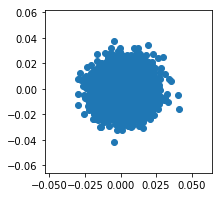

Epoch 1/1
53500/53500 [==============================] - 19s 363us/step - loss: 0.6667


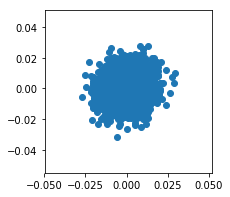

Epoch 1/1
53500/53500 [==============================] - 19s 359us/step - loss: 0.6664


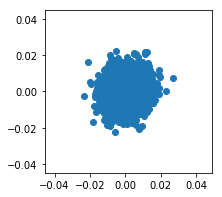

Epoch 1/1
53500/53500 [==============================] - 19s 359us/step - loss: 0.6664


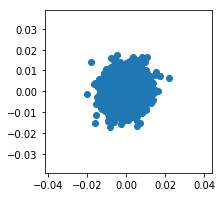

Epoch 1/1
53500/53500 [==============================] - 19s 358us/step - loss: 0.6664


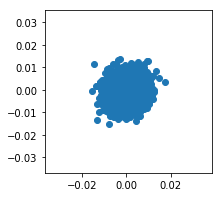

Epoch 1/1
53500/53500 [==============================] - 19s 358us/step - loss: 0.6664


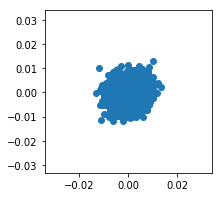

Epoch 1/1
53500/53500 [==============================] - 19s 353us/step - loss: 0.6664


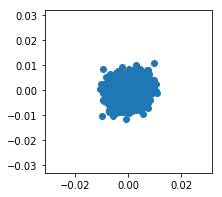

Epoch 1/1
53500/53500 [==============================] - 19s 355us/step - loss: 0.6664


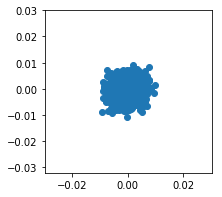

Epoch 1/1
53500/53500 [==============================] - 19s 360us/step - loss: 0.6664


KeyboardInterrupt: 

In [50]:
vae = VAE(timesteps, batch_size, latent_dim, run_dir, img_dir, model_dir, generated_datesets_dir)
vae_model, generator, encoder = vae.build_models(lr)

losses = vae.train(batch_size, epochs, transactions, img_frequency, model_save_frequency, dataset_generation_frequency, dataset_generation_size)

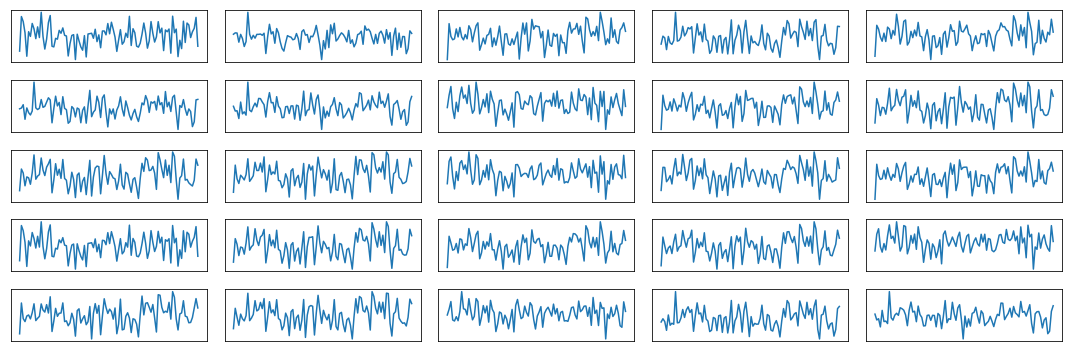

In [51]:
rows, columns = 5, 5
noise = np.random.normal(0, 1, (rows * columns, latent_dim))
generated_samples = generator.predict(noise)

plt.subplots(rows, columns, figsize=(15, 5))
k = 1
for i in range(rows):
    for j in range(columns):
        plt.subplot(rows, columns, k)
        plt.plot(generated_samples[k - 1])
        plt.xticks([])
        plt.yticks([])
        k += 1
plt.tight_layout()
plt.show()